# Potholes Detection System

In [2]:
import numpy as np # linear algebra
import os # operating system

In [3]:
from keras.utils import set_random_seed
set_random_seed(812)

In [4]:
#connecting google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
#changing directory to working directory
%cd /content/gdrive/MyDrive/Pearl Hacks

/content/gdrive/MyDrive/Pearl Hacks


# Data Exploration

The data is split into normal images, images with potholes, images with flood/water logging, and images with litter.

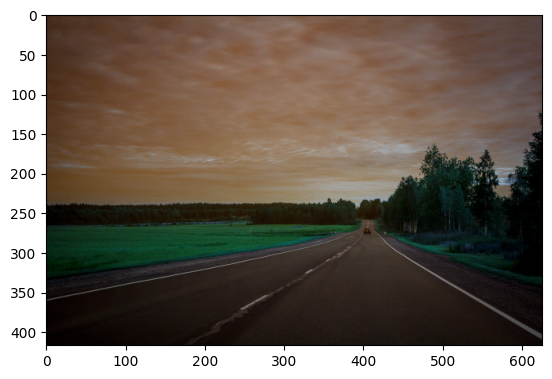

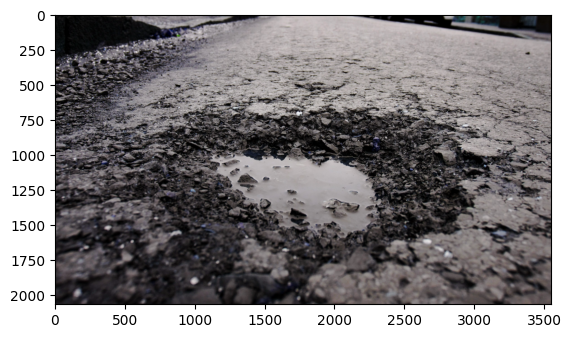

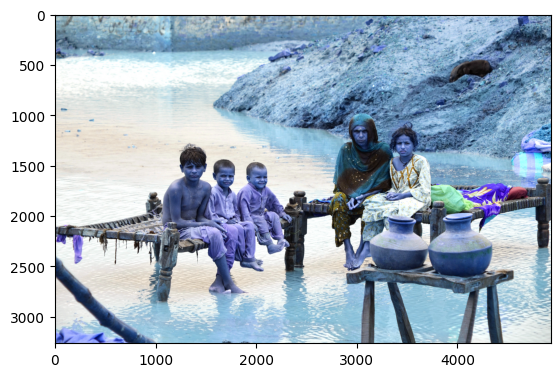

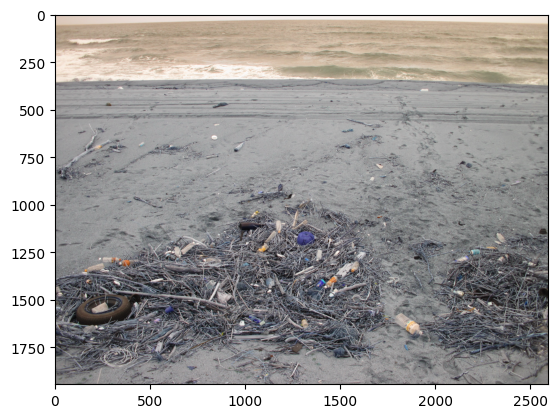

In [6]:
import cv2
import matplotlib.pyplot as plt

def explore_dir(dir_path, count):
    for _, _, filenames in os.walk(dir_path):
        for i in range(count):
            img = cv2.imread(os.path.join(dir_path, filenames[i]))
            plt.imshow(img)
            plt.show()

normal_dir = 'normal'
potholes_dir = 'potholes'
flood_dir = 'flood'
litter_dir = 'litter'

explore_dir(normal_dir, 1)
explore_dir(potholes_dir, 1)
explore_dir(flood_dir, 1)
explore_dir(litter_dir, 1)

Let's make sure the dataset is well-balanced by counting the number of pictures in each directory.

In [7]:
def count_files(dir_path):
    file_count = 0
    for _, _, filenames in os.walk(dir_path):
        file_count += len(filenames)
    return file_count

print('Normal images: ', count_files(normal_dir))
print('Potholes images: ', count_files(potholes_dir))
print('Flood images: ', count_files(flood_dir))
print('Litter images: ', count_files(litter_dir))

Normal images:  352
Potholes images:  329
Flood images:  330
Litter images:  345


# Data Pre-processing and Augmentation

Let's group all the images in a single dataset X. Normal images will be assigned the label Y = 0; whereas images with potholes will be assigned Y = 1.
While we are at it, let's normalize the images to have the same 150x150 size.

In [8]:
desired_size = (150, 150)
X, Y = [], []

def add_images(dir_path, label):
    for _, _, filenames in os.walk(dir_path):
        for file in filenames:
            try:
                img = cv2.imread(os.path.join(dir_path, file))
                img = cv2.resize(img, desired_size)
                X.append(np.array(img))
                Y.append(label)
            except:
                print('Image ' + os.path.join(dir_path, file) + ' could not be resized')

add_images(normal_dir, 0)
add_images(potholes_dir, 1)
add_images(flood_dir, 2)
add_images(litter_dir, 3)

Image normal/226.jpg could not be resized


In [9]:
print(f"Dataset size: X = {len(X)}, Y = {len(Y)}")

Dataset size: X = 1355, Y = 1355


We will augment the dataset by flipping each image and adding the obtained image to the dataset.

In [10]:
import tensorflow as tf

img_count = len(X)
for i in range(img_count):
    flipped = tf.image.flip_left_right(X[i])
    X.append(flipped)
    Y.append(Y[i])
print(img_count)

1355


Let's visualize some of the flipped images

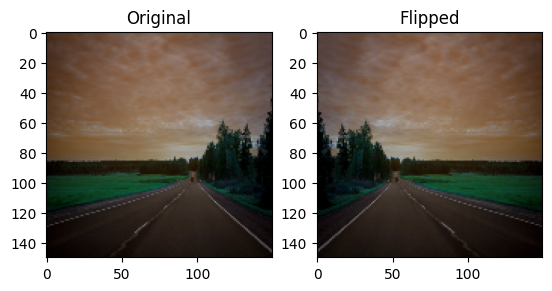

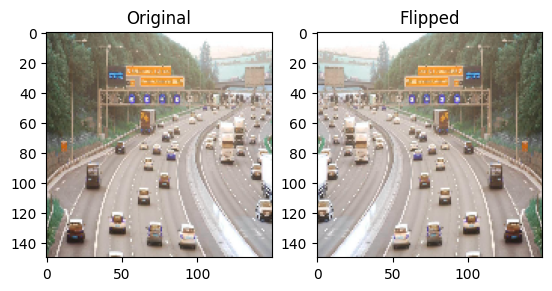

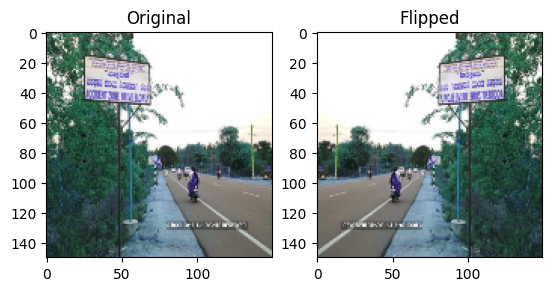

In [11]:
to_visualize = 3

for i in range(to_visualize):
    plt.subplot(1, 2, 1).imshow(X[i])
    plt.title('Original')
    plt.subplot(1, 2, 2).imshow(X[img_count + i])
    plt.title('Flipped')
    plt.show()

We need to encode the Y labels to be categorical variables.

In [12]:
from keras.utils import to_categorical

Y = to_categorical(Y,4)
print(Y)

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


Let's split the dataset X into train and test with an 80/20 split.

In [13]:
from sklearn.model_selection import train_test_split

X = np.array(X)
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.20, random_state=5, shuffle=True)

print(x_train.shape)
print(x_test.shape)

(2168, 150, 150, 3)
(542, 150, 150, 3)


In [14]:
from keras.preprocessing.image import ImageDataGenerator

# Data Augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=40,  # Random rotations
    width_shift_range=0.2,  # Random horizontal shifts
    height_shift_range=0.2,  # Random vertical shifts
    shear_range=0.2,  # Shearing
    zoom_range=0.2,  # Zooming
    horizontal_flip=True,  # Horizontal flipping
    fill_mode='nearest'
)

# Only rescaling for validation data
validation_datagen = ImageDataGenerator(rescale=1./255)

# Preparing data generators
train_generator = train_datagen.flow(x_train, y_train, batch_size=32)
validation_generator = validation_datagen.flow(x_test, y_test, batch_size=32)


# CNN Model

Let's now create a model that's better fit for tasks involving images. We will use a Convolutional Neural Network.

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(4, activation='softmax')
])


In [16]:
# print model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

As before, we will use categorical cross-entropy as loss and an early-stopping callback.

In [17]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

In [19]:
history = model.fit(
    train_generator,
    epochs=20,
    batch_size = 32,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
68/68 [==============================] - 149s 2s/step - loss: 2.0925 - accuracy: 0.4479 - val_loss: 1.7287 - val_accuracy: 0.5923 - lr: 1.0000e-04
Epoch 2/20
68/68 [==============================] - 151s 2s/step - loss: 1.5517 - accuracy: 0.6102 - val_loss: 1.3397 - val_accuracy: 0.7454 - lr: 1.0000e-04
Epoch 3/20
68/68 [==============================] - 150s 2s/step - loss: 1.3376 - accuracy: 0.6817 - val_loss: 1.2631 - val_accuracy: 0.6790 - lr: 1.0000e-04
Epoch 4/20
68/68 [==============================] - 152s 2s/step - loss: 1.2401 - accuracy: 0.6956 - val_loss: 1.1334 - val_accuracy: 0.7251 - lr: 1.0000e-04
Epoch 5/20
68/68 [==============================] - 150s 2s/step - loss: 1.1330 - accuracy: 0.7311 - val_loss: 1.0278 - val_accuracy: 0.7509 - lr: 1.0000e-04
Epoch 6/20
68/68 [==============================] - 149s 2s/step - loss: 1.0818 - accuracy: 0.7205 - val_loss: 0.9298 - val_accuracy: 0.7823 - lr: 1.0000e-04
Epoch 7/20
68/68 [==============================] - 

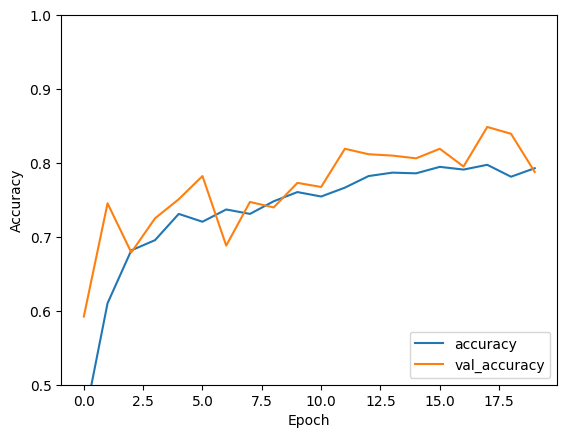

In [20]:
# plot the training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [21]:
# print the achieved accuracy
cnn_test_loss, cnn_test_acc = model.evaluate(x_test,  y_test, verbose=2)
print('Best accuracy: ', cnn_test_acc)

17/17 - 9s - loss: 42.9421 - accuracy: 0.8358 - 9s/epoch - 522ms/step
Best accuracy:  0.8357933759689331


In [22]:
# loading library
import pickle

In [23]:
# create an iterator object with write permission - model.pkl
with open('prediction_l2.pkl', 'wb') as files:
    pickle.dump(model, files)